In [1]:
# Import Library
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
import cv2 as cv

In [2]:
# Setting model as VGG19
custom_model = models.vgg19(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 121MB/s] 


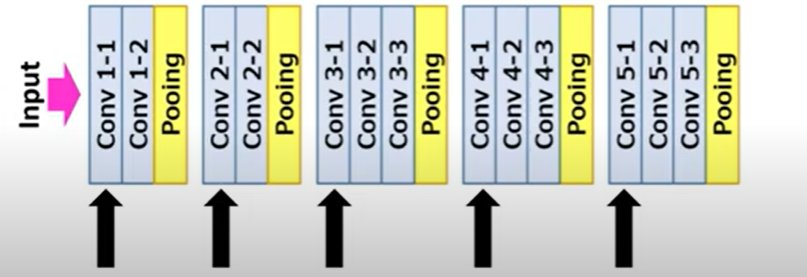

In [3]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        # The first number x in convx_y gets added by 1 after it has gone
        # through a maxpool, and the second y if we have several conv layers
        # in between a max pool. These strings (0, 5, 10, ..) then correspond
        # to conv1_1, conv2_1, conv3_1, conv4_1, conv5_1 mentioned in NST paper
        self.chosen_features = ["0", "5", "10", "19", "28"]

        # We don't need to run anything further than conv5_1 (the 28th module in vgg)
        # Since remember, we dont actually care about the output of VGG: the only thing
        # that is modified is the generated image (i.e, the input).
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        # Store relevant features
        features = []

        # Go through each layer in model, if the layer is in the chosen_features,
        # store it in features. At the end we'll just return all the activations
        # for the specific layers we have in chosen_features
        for layer_num, layer in enumerate(self.model):
            x = layer(x)

            if str(layer_num) in self.chosen_features:
                features.append(x)

        return features

In [4]:
def load_image(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 356

In [6]:
loader = transforms.Compose(
    [
        transforms.Resize((imsize, imsize)),
        transforms.ToTensor(),
    ]
)

In [8]:
original_img_path = '/content/content2.jpeg'
style_img_path = '/content/style2.jpeg'
original_img = load_image(original_img_path)
style_img = load_image(style_img_path)

In [9]:
generated = original_img.clone().requires_grad_(True)
model = VGG().to(device).eval()

### we can also train alpha and beta hyperparameters. Due to time and computational resource constraint, It is made simple

In [10]:
# Hyerparameters
total_steps = 6000
learning_rate = 0.001
alpha = 1
beta = 0.01
optimizer = optim.Adam([generated],lr = learning_rate)
for step in range(total_steps):
    # Obtain the convolution features in specifically chosen layers
    generated_features = model(generated)
    original_img_features = model(original_img)
    style_features = model(style_img)

    # Loss is 0 initially
    style_loss = original_loss = 0

    # iterate through all the features for the chosen layers
    for gen_feature, orig_feature, style_feature in zip(
        generated_features, original_img_features, style_features
    ):

        # batch_size will just be 1
        batch_size, channel, height, width = gen_feature.shape
        original_loss += torch.mean((gen_feature - orig_feature) ** 2)
        # Compute Gram Matrix of generated
        G = gen_feature.view(channel, height * width).mm(
            gen_feature.view(channel, height * width).t()
        )
        # Compute Gram Matrix of Style
        A = style_feature.view(channel, height * width).mm(
            style_feature.view(channel, height * width).t()
        )
        style_loss += torch.mean((G - A) ** 2)

    total_loss = alpha * original_loss + beta * style_loss
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if step % 200 == 0:
        print(total_loss)
        save_image(generated, "generated.png")

tensor(513693.8438, device='cuda:0', grad_fn=<AddBackward0>)
tensor(72925.6719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38917.5703, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18710.4141, device='cuda:0', grad_fn=<AddBackward0>)
tensor(8988.2021, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5478.7300, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4184.4751, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3515.8193, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3053.7319, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2692.2190, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2390.3010, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2136.4751, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1926.7764, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1753.8374, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1610.4835, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1490.8947, device='cuda:0', grad_fn=<AddBackward0>)
tensor(1389.8496, device='cuda:0', grad_fn=<AddBack

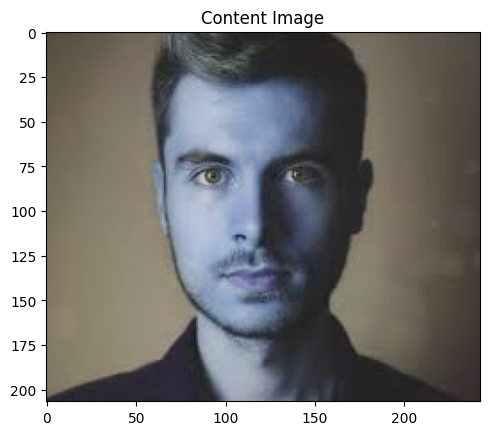

In [11]:
content_image = cv.imread(original_img_path)
style_image = cv.imread(style_img_path)

plt.title('Content Image')
plt.imshow(content_image)

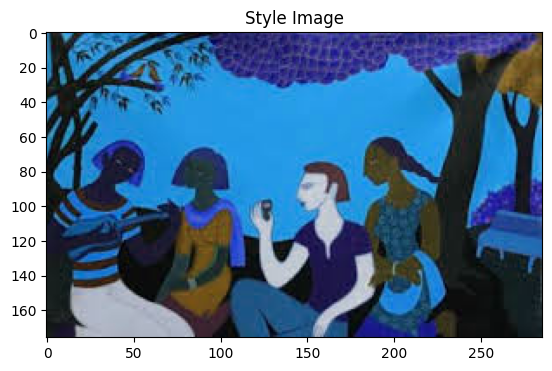

In [12]:
plt.title('Style Image')
plt.imshow(style_image)

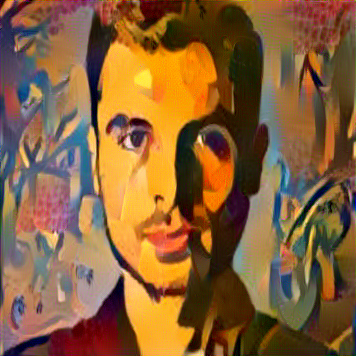

In [16]:
#style transfered to content image
path="/content/generated.png"
display(Image.open(path))